In [40]:
!pip install -U "ray[rllib]" gymnasium

  Using cached gymnasium-0.29.1-py3-none-any.whl (953 kB)


In [41]:
import ray
import numpy as np
import gymnasium as gym
from gymnasium.spaces import Box
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle

In [42]:
profet_path = str(input("Enter the path of prophet_model.pkl"))

In [43]:
class ManufactoringState(object):
    def __init__(self, manufacturing_rate=10, current_stock_raw_material=10, current_product_stock=0, demand_history=[], raw_material_history=[]):
        self.manufacturing_rate = manufacturing_rate
        self.current_stock_raw_material = current_stock_raw_material
        self.current_product_stock = current_product_stock
        self.demand_history = demand_history
        self.raw_material_history = raw_material_history
        self.time = 0

    def to_array(self, ):
        return np.hstack((np.array(self.manufacturing_rate), np.array(self.current_product_stock), np.array(self.current_stock_raw_material), np.array(self.demand_history), np.array(self.raw_material_history)))

In [44]:
temp = ManufactoringState()
temp.to_array()

array([10.,  0., 10.])

In [45]:
class SimpleSupplyChain(gym.Env):
    def __init__(self, config):
        self.T = 365
        self.t = 1
        self.state = ManufactoringState()
        self.done = False
        self.observaiton_list = []

        # add realtime transportation time by agent using demand
        self.transportation_time = 2
        self.transportation_cost = 10
        self.raw_material_cost = 10
        self.main_cost = 100
        self.production_cost_per_product = 10
        self.max_manufacturing_rate = 100
        self.product_capacity = 1000
        self.selling_price = 100
        self.raw_material_capacity = 3000
        self.require_raw_material_per_product = 3

        # [manufacturing_rate, current_product_stock, current_raw_material_stock, 15 demand history, 15 raw material history]
        self.observation_space = Box(low=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), high=np.array([self.max_manufacturing_rate, self.product_capacity,
                                     self.raw_material_capacity, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000]), dtype=np.int64)
        self.reset()
        self.action_space = Box(low=np.array([1, 0]), high=np.array(
            [self.max_manufacturing_rate, self.raw_material_capacity]), dtype=np.int64)

    def get_demand(self, t):
        date = str(datetime.today()+timedelta(days=int(t)))[:11]
        # print(date)
        with open(profet_path, 'rb') as f:
            m = pickle.load(f)
            future_dates = pd.DataFrame({'ds': [date]})
            forecast = m.predict(future_dates)
            return forecast['yhat'][0]/100

    def reset(self, seed=None, options=None):
        # print("It's in reset", id(self), id(self.t), self.t)
        observations = self.observation_space.sample()
        self.observaiton_list = []
        self.state.manufacturing_rate = 0
        self.state.current_product_stock = 0
        self.state.demand_history = [self.get_demand(
            self.state.time+i) for i in range(15)]
        self.state.raw_material_history = observations[18:33]
        self.state.manufacturing_rate = 0
        self.state.current_stock_raw_material = 0
        self.state.time = 0
        self.observaiton_list.append(self.state)
        self.max_score = float('-inf')
        self.score = 0
        self.t = 1
        self.done = False
        # intialize demand history with starting_values
        return observations, {}

    def step(self, action):
        new_manufacturing_rate = action[0]
        new_raw_material_stock = action[1]
        self.t += 1

        # how much maximum we can go in manufacturing
        if new_manufacturing_rate > self.max_manufacturing_rate:
            new_manufacturing_rate = self.max_manufacturing_rate

        new_possible_stock = new_manufacturing_rate * 24
        
        if new_possible_stock + self.state.current_product_stock > self.product_capacity:
            new_possible_stock = self.product_capacity - self.state.current_product_stock

        # how much we can actually produce with the raw material
        if new_possible_stock*self.require_raw_material_per_product > self.state.current_stock_raw_material:
            new_possible_stock = np.floor(
                self.state.current_stock_raw_material/self.require_raw_material_per_product)

        new_manufacturing_rate = new_possible_stock/(24-self.transportation_time)

        # how much raw material we can store
        if (self.state.current_stock_raw_material + new_raw_material_stock - (new_possible_stock*self.require_raw_material_per_product)) > self.raw_material_capacity:
            new_raw_material_stock = self.raw_material_capacity - self.state.current_stock_raw_material + \
                (new_possible_stock*self.require_raw_material_per_product)

        # what can be fullfiled with this time limit
        if (24 - self.transportation_time) < new_possible_stock/new_manufacturing_rate:
            new_possible_stock = (24-self.transportation_time)*new_manufacturing_rate
            
        total_products_to_deliver = min(new_possible_stock+self.state.current_product_stock, self.state.demand_history[0])

        revenue = self.selling_price*total_products_to_deliver
        total_costs = (self.production_cost_per_product * new_possible_stock) + self.main_cost + \
            (self.raw_material_cost * new_raw_material_stock) + \
            self.transportation_cost

        reward = revenue - total_costs

        # create new state
        previous_demands = self.state.demand_history[0:14]
        self.state.demand_history[0] = self.get_demand(self.t)
        self.state.demand_history[1:15] = previous_demands

        previous_raw_history = self.state.raw_material_history[0:14]
    #    print(self.state.raw_material_history)
        self.state.raw_material_history[0] = new_raw_material_stock
        self.state.raw_material_history[1:15] = previous_raw_history
    #    print(self.state.raw_material_history)
        self.state = ManufactoringState(new_manufacturing_rate, self.state.current_stock_raw_material + new_raw_material_stock - (new_possible_stock*self.require_raw_material_per_product),
                                        (new_possible_stock + self.state.current_product_stock - total_products_to_deliver), self.state.demand_history, self.state.raw_material_history)

        if self.t == self.T:
            self.done = True

        return self.state.to_array(), reward, self.done, False, {}

In [46]:
temp = SimpleSupplyChain(1)

In [47]:
temp.step([1, 0])

/tmp/ipykernel_10909/2056059596.py:84: RuntimeWarning: invalid value encountered in scalar divide
  if (24 - self.transportation_time) < new_possible_stock/new_manufacturing_rate:


(array([   0.        ,    0.        ,    0.        ,  453.38561054,
         417.39650986,  451.97092916,  453.38561054,  470.37314488,
         488.31933657,  505.65999566,  523.5857383 ,  423.42838894,
         457.44704059,  458.3352647 ,  474.83423449,  492.33725738,
         509.28641985,  526.87727688,    0.        ,    0.        ,
        1302.        , 2564.        ,  324.        , 2352.        ,
        1483.        ,  565.        , 2313.        ,  533.        ,
        2227.        , 2901.        , 1661.        , 1496.        ,
         383.        ]),
 -110.0,
 False,
 False,
 {})

In [48]:
import ray
from ray import tune

from ray.rllib.algorithms.sac.sac import SACConfig
from ray.air import session
from ray import air
# Ensure that 'air' and 'tune' are not imported twice

# Define your custom gym environment and related classes like SupplyChainEnvironment and Action
# as before, ensuring they are correctly implemented

ray.shutdown()
ray.init(num_gpus=0)

my_results = None


def train_ppo(config, stop_criteria):
    if ray.is_initialized():
        ray.shutdown()
    ray.init()

    config.update({
        "num_workers": 0,
        "num_gpus": 0,  # educe the number of workers to ensure it fits within available resources
        "env": SimpleSupplyChain,
        # It's important to specify how many CPUs each worker can utilize
        # This setting helps when your tasks can run with less than a full core per worker
        # "num_cpus_per_worker": 1,  # This can be adjusted based on your environment's needs
    })

    # Using 'tune.Tuner' for a more updated approach, if applicable based on your Ray version
    tuner = tune.Tuner(
        "PPO",
        param_space=config,
        run_config=air.RunConfig(
            stop=stop_criteria, name="PPO_SimpleSupplyChain")
    )
    global my_results
    my_results = tuner.fit()


# Execute the training function
if __name__ == "__main__":
    config = {
        "lr": tune.grid_search([0.001]),  # Learning rate grid search example
        # Other PPO configurations can go here
    }
    stop_criteria = {
        "training_iteration": 1,
        # You can adjust the stop criteria as needed
    }
    train_ppo(config, stop_criteria)

(PPO pid=69854) Importing plotly failed. Interactive plots will not work.
(PPO pid=69854) 2024-04-15 15:12:28,500	WARNING env.py:162 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(PPO pid=69854) /tmp/ipykernel_10909/2056059596.py:84: RuntimeWarning: invalid value encountered in scalar divide
(PPO pid=69854) Install gputil for GPU system monitoring.
(PPO pid=69854) /tmp/ipykernel_10909/2056059596.py:84: RuntimeWarning: invalid value encountered in scalar divide
(PPO pid=69854) /tmp/ipykernel_10909/2056059596.py:84: RuntimeWarning: invalid value encountered in scalar divide
(PPO pid=69854) /tmp/ipykernel_10909/2056059596.py:84: RuntimeWarning: invalid value encountered in scalar divide
(PPO pid=69854) /tmp/ipykernel_10909/2056059596.py:84: RuntimeWarning: invalid value encountered in scalar divide
(PPO pid=69854) /tmp/ipykernel_10909/2056059596.py:84: RuntimeWarning: invalid value encountered i

In [ ]:
from ray.rllib.algorithms.algorithm import Algorithm
best_result = my_results.get_best_result()
print(best_result)

model_ppo = Algorithm.from_checkpoint(best_result.checkpoint)
# model_ppo = Algorithm.from_checkpoint(r"C:\Users\Harsh\ray_results\PPO_SimpleSupplyChain\PPO_SimpleSupplyChain_91627_00000_0_lr=0.0010_2024-04-15_11-09-46\checkpoint_000000")


Result(
  metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 0.3952213691502449, 'cur_kl_coeff': 0.20000000000000004, 'cur_lr': 0.0010000000000000005, 'total_loss': 9.756109211009036, 'policy_loss': -0.24965775626341022, 'vf_loss': 10.0, 'vf_explained_var': 0.0, 'kl': 0.028834746065102983, 'entropy': 15.983281446272327, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 128.0, 'num_grad_updates_lifetime': 465.5, 'diff_num_grad_updates_vs_sampler_policy': 464.5}}, 'num_env_steps_sampled': 4000, 'num_env_steps_trained': 4000, 'num_agent_steps_sampled': 4000, 'num_agent_steps_trained': 4000}, 'sampler_results': {'episode_reward_max': 9662903.63587731, 'episode_reward_min': 9257711.003565464, 'episode_reward_mean': 9464249.814783134, 'episode_len_mean': 364.0, 'episode_media': {}, 'episodes_this_iter': 10, 'policy_reward_min': {}, 'policy_reward_max': {}, 'po

c:\Users\Harsh\Desktop\reinforcement_learning\.venv\lib\site-packages\ray\rllib\algorithms\algorithm.py:500: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
c:\Users\Harsh\Desktop\reinforcement_learning\.venv\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
c:\Users\Harsh\Desktop\reinforcement_learning\.venv\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationW

In [ ]:
import matplotlib.pyplot as plt
from transportation import get_locationiq_routes,Transportation
import numpy as np
def get_demand(t):
    date = str(datetime.today()+timedelta(days=int(t)))[:11]
    # print(date)
    with open(profet_path, 'rb') as f:
        m = pickle.load(f)
        future_dates = pd.DataFrame({'ds': [date]})
        forecast = m.predict(future_dates)
        return forecast['yhat'][0]/100


state = ManufactoringState()

# add realtime transportation time by agent using demand
transportation_time = 2
transportation_cost = 10
raw_material_cost = 10
main_cost = 100
production_cost_per_product = 10
max_manufacturing_rate = 100
product_capacity = 1000
selling_price = 100
raw_material_capacity = 3000
require_raw_material_per_product = 3

profit_list = []
current_product_stock_list = []
current_raw_material_stock_list = []
manufactured_product_list = []
new_raw_material_list = []
manufacturing_rate_list = []
total_products_delivered_list = []
demand_list = []
production_cost_list = []
revenue_list = []

#get source and destination address
total_parcels = 0
vehicals_capacity = str(input("Enter capacity of your unique vehicles seperated by space. -> capacity_for_v1 capacity_for_v2 ")).split(" ")
vehicals_cost = str(input("Enter cost of each vehical per KM seperated by space. -> cost_for_v1 cost_for_v2 ")).split(" ")
num_of_vehicals_per_type = str(input("Enter number of vehicals instance for each type seperated by space. -> count_for_v1 count_for_v2 ")).split(" ")
soucre_address = str(input("Enter source address: "))
destination_address = str(input("Enter destination address: "))
routes_info = get_locationiq_routes(source=soucre_address,destination= destination_address)
routes_km = routes_info['distance']
routes_time = routes_info['duration']

vehicals_capacity = [int(x) for x in vehicals_capacity]
vehicals_cost = [int(x) for x in vehicals_cost]
num_of_vehicals_per_type = [int(x) for x in num_of_vehicals_per_type]
routes_km = [int(x) for x in routes_km]
routes_time = [int(x) for x in routes_time]

state.demand_history = [get_demand(time) for time in range(15)]
state.raw_material_history = [0 for i in range(15)]

for i in range(15):
    current_state = state.to_array()
    action = model_ppo.compute_single_action(current_state)
    new_manufacturing_rate, new_raw_material_stock = action

    #calculate transportation time :
    transportation_obj  = Transportation(int(np.floor(state.demand_history[0])),vehicals_capacity,vehicals_cost,num_of_vehicals_per_type,routes_km,routes_time,0.5)
    transportation_cost,transportation_time = transportation_obj.inference()
    transportation_time /=60
    if new_manufacturing_rate > max_manufacturing_rate:
        new_manufacturing_rate = max_manufacturing_rate

    new_possible_stock = new_manufacturing_rate * 24

    # how much we can actually produce with the raw material
    if new_possible_stock*require_raw_material_per_product > state.current_stock_raw_material:
        new_possible_stock = np.floor(
            state.current_stock_raw_material/require_raw_material_per_product)
        
    if new_possible_stock+state.current_product_stock > product_capacity:
        new_possible_stock = product_capacity - state.current_product_stock
        
    new_manufacturing_rate = new_possible_stock/(24-transportation_time)
        
    # how much raw material we can store
    if (state.current_stock_raw_material + new_raw_material_stock - (new_possible_stock*require_raw_material_per_product)) > raw_material_capacity:
        new_raw_material_stock = raw_material_capacity - state.current_stock_raw_material + \
            (new_possible_stock*require_raw_material_per_product)

    # what can be fullfiled with this time limit
    total_products_to_deliver = min(
        new_possible_stock+state.current_product_stock, state.demand_history[0])
    if (24 - transportation_time) < total_products_to_deliver/new_manufacturing_rate:
        total_products_to_deliver = (
            24-transportation_time)*new_manufacturing_rate

    revenue = selling_price*total_products_to_deliver
    total_costs = (production_cost_per_product * new_possible_stock) + main_cost + \
        (raw_material_cost * new_raw_material_stock) + transportation_cost

    current_product_stock_list.append(state.current_product_stock)
    current_raw_material_stock_list.append(state.current_stock_raw_material)
    manufactured_product_list.append(new_possible_stock)
    new_raw_material_list.append(new_raw_material_stock)
    manufacturing_rate_list.append(new_manufacturing_rate)
    total_products_delivered_list.append(total_products_to_deliver)
    demand_list.append(state.demand_history[0])
    production_cost_list.append(total_costs)
    revenue_list.append(revenue)
    reward = revenue - total_costs
    previous_demands = state.demand_history[0:14]
    state.demand_history[0] = get_demand(15+i)
    state.demand_history[1:15] = previous_demands

    previous_raw_history = state.raw_material_history[0:14]
    state.raw_material_history[0] = new_raw_material_stock
    state.raw_material_history[1:15] = previous_raw_history
    state = ManufactoringState(new_manufacturing_rate, state.current_stock_raw_material + new_raw_material_stock - (new_possible_stock*require_raw_material_per_product),
                               (new_possible_stock + state.current_product_stock - total_products_to_deliver), state.demand_history, state.raw_material_history)

    profit_list.append(reward)
    print()
    print("Day number:", i+1)
    print("Current stock is:", state.current_product_stock)
    print("agent requests for {} this much products".format(new_possible_stock))
    print("demand for next 15 days is:", state.demand_history)
    print("manufucturing cost:", total_costs)
    print("Profit:", reward)
    print()

KeyError: 0

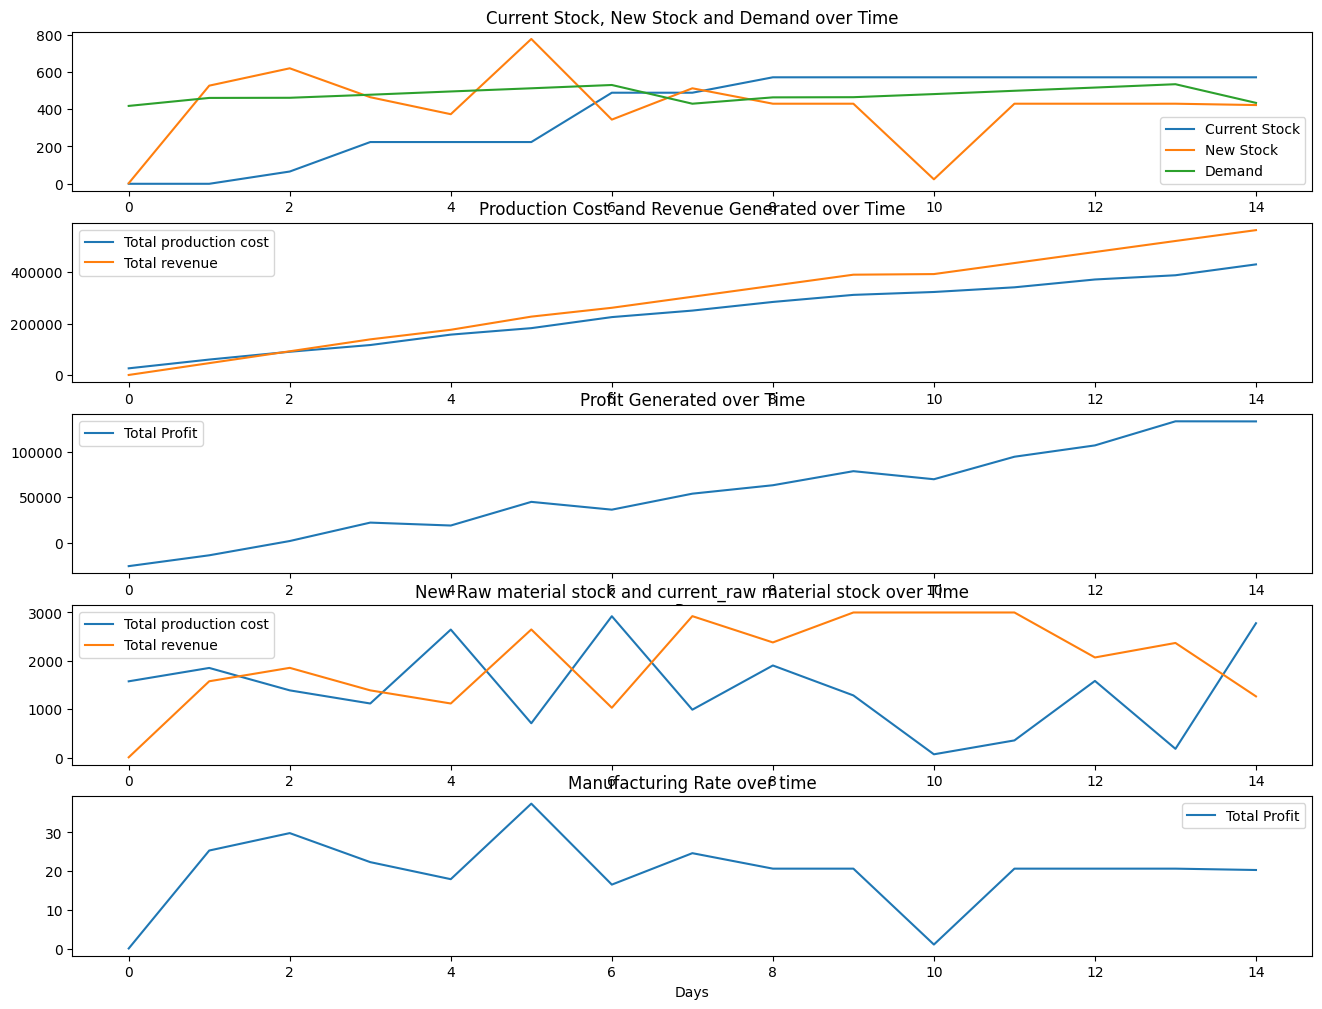

In [ ]:
fig, axs = plt.subplots(5, figsize=(16, 12))

axs[0].plot([i for i in range(len(current_product_stock_list))],
            current_product_stock_list, label='Current Stock')
axs[0].plot([i for i in range(len(manufactured_product_list))],
            manufactured_product_list, label='New Stock')
axs[0].plot([i for i in range(len(demand_list))], demand_list, label='Demand')
axs[0].set_title('Current Stock, New Stock and Demand over Time')
axs[0].legend()

axs[1].plot([i for i in range(len(np.cumsum(production_cost_list)))],
            np.cumsum(production_cost_list), label='Total production cost')
axs[1].plot([i for i in range(len(np.cumsum(revenue_list)))],
            np.cumsum(revenue_list), label='Total revenue')
axs[1].set_title('Production Cost and Revenue Generated over Time')
axs[1].legend()

axs[2].plot([i for i in range(len(np.cumsum(profit_list)))],
            np.cumsum(profit_list), label='Total Profit')
axs[2].set_xlabel('Days')
axs[2].set_title('Profit Generated over Time')
axs[2].legend()


axs[3].plot([i for i in range(len((new_raw_material_list)))],
            (new_raw_material_list), label='Total production cost')
axs[3].plot([i for i in range(len((current_raw_material_stock_list)))],
            (current_raw_material_stock_list), label='Total revenue')
axs[3].set_title(
    'New Raw material stock and current_raw material stock over Time')
axs[3].legend()

axs[4].plot([i for i in range(len((manufacturing_rate_list)))],
            (manufacturing_rate_list), label='Total Profit')
axs[4].set_xlabel('Days')
axs[4].set_title('Manufacturing Rate over time')
axs[4].legend()

plt.show()